# MCMC - Markov Chain Monte Carlo
- 为什么需要采样？
 
 在概率图模型的推断问题中（Inference），如果要精确推断，会计算一个很复杂的积分形式: $$P(Z|X) = \frac{P(X|Z)P(Z)}{\int p(X|Z)p(Z)dZ}$$
 
 在假定图模型的参数都已经学习（learning）出来的情况下，如果分布是易于计算的，如高斯分布，变量之间又符合线性高斯关系（如卡曼滤波），此时是可以求出推断问题的解析解的。
 
 但当变量之间的条件概率分布非线性，此时上述的积分问题就是**intractable**的，对于$P(Z=z|X=x)$的估计就需要采样，用频率来估计。
 
 而吉布斯采样仅仅需要知道概率分布$P(z_i|-\{z_i\},X=x)$,这个基于图参数是可以计算的。远没有积分难算。 
   
- 问题引出

 采样的办法有很多，在计算机解决了伪随机数产生之后，有概率分布采样、接受-拒绝采样、重要性采样等方法。
 
 重要性采样和拒绝-接受采样对 propose dist的要求较高

- Markov链的想法
 
 Markov chain 具有达到平稳状态分布的性质，这点启发我们可以用一个达到平稳分布为采样目标分布的$P(X)$来采样。
 
- Markov 性质
 
 $$P(X_{t+1}| X_{1:t}) = P(X_{t+1} |X_{t})$$
 状态转移 矩阵（概率分布）满足马尔科夫性质，初始化分布$\pi(X)$, 最终会达到收敛：$\pi(x_{t+1}) = Q\pi(x_t) (1)$, 
 
 现在的目标就是找到一个这样的$Q$使得平稳后的分布$\pi$为目标分布$P$.
 
- 细致平稳条件

 从平稳条件**(1)** 式不能找到解出$Q$的方法，下面引出一个细致平稳条件： $$\pi(i)P(i, j) = \pi(j)P(j, i) (2)$$
 可以证明这是收敛性的充分条件，这个条件能使得依据$P$采样最后平稳到$\pi$分布。
 
 但通常情况下(2)式不相等的：$\pi(i)Q(i, j) \neq \pi(j)Q(j, i)$
 
 需要找到这样一个满足条件的$\alpha$ 使两边相等：$$\pi(i)Q(i, j)\alpha(i,j) \neq \pi(j)Q(j, i)\alpha(j,i)$$
 $$\alpha(i, j) = \pi(j)Q(j, i)$$
 
 那么就可以得到分布$\pi(x)$平稳对应的马尔科夫转移矩阵(概率分布) $P(i,j) = Q(i,j)\alpha(i,j) (3)$
 
 **（3）式的具体用法是用来采样**， 即，j的产生于$Q$采样之后，还要符合$\alpha$的概率，此时的办法跟**拒绝接受采样**和**CDF采样**的办法一样，先试用均匀分布采样，然后依据$\alpha$判断是否拒绝。
 
- M-H 采样改进

 上面的采样办法已经可以了，但是效率不高，就是达到平稳分布前的时间太长；原因是$\alpha$通常太小了。为了解决这个问题，回到（3）式，使其中一边较大的放大到1，此时可得$$\alpha(i,j) = min \{ 1, \frac{\pi(j)Q(j,i)}{\pi(i)Q(i,j)} \} $$
 
 这样就得出了M-H采样算法：
 
 **Algorithm1 M-H Sampling**
 
 - 从t=0时刻开始，从条件概率分布$Q(x |x_t)$ 取得样本 $x^*$
 - 采样 $u \sim U(0,1)$
 - 如果 u < $\alpha(x^*, x_t) = min \{ 1, \frac{\pi(*)Q(*,x_t)}{\pi(x_t)Q(x_t,*)}$, 则接受 $x_{t+1} = x^*$ 否则$x_{t+1} = x_t$

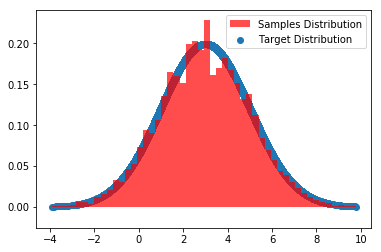

In [129]:
# M-H实现
import random
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
def norm_dist_prob(theta):
    y = norm.pdf(theta, loc=3, scale=2)
    return y

def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

T = 20000

S = 5000
value_scope = np.linspace(-5, 10, S)

Q = np.random.randint(0, 10, size=(S ,S))
Q = Q / np.sum(Q, axis=0)
Q = Q.T
pi = [0 for i in range(T)]
sigma = 1
t = 0
n = 0
N = 1
while n < N:
    t = 0
    index = t
    while t < T-1:
        t = t + 1
    #     pi_star = norm.rvs(loc=pi[t - 1], scale=sigma, size=1, random_state=None)   #状态转移进行随机抽样
        new_index = np.random.choice(np.arange(S), p=Q[index, :])
        pi_star = value_scope[new_index]
        alpha = min(1, (norm_dist_prob(pi_star) * Q[new_index, index])/ (norm_dist_prob(pi[t-1])*Q[index, new_index]))
        u = random.uniform(0, 1)
        if u < alpha:
            pi[t] = pi_star
            index = new_index
        else:
            pi[t] = pi[t - 1]
    n += 1

plt.scatter(pi, norm.pdf(pi, loc=3, scale=2),label='Target Distribution')
num_bins = 50
plt.hist(pi, num_bins, normed=1, facecolor='red', alpha=0.7,label='Samples Distribution')
plt.legend()
plt.show()

### Gibbs Sampling
在随机变量是多维的情况时，高维转移矩阵增加了计算难度，但是经过探索发现，直接使用边缘条件分布采样也能达到一样的细致平稳条件。

于是Gibbs采样就是对多维随机变量分别采样，最后达到平稳的方法。

/root/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


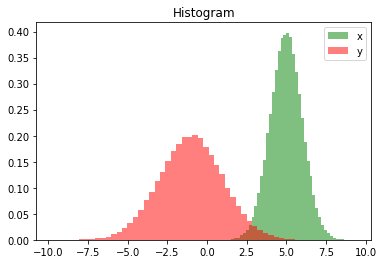

In [104]:
import math
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

samplesource = multivariate_normal(mean=[5,-1], cov=[[1,0.5],[0.5,2]])

def p_ygivenx(x, m1, m2, s1, s2):
    return (random.normalvariate(m2 + rho * s2 / s1 * (x - m1), math.sqrt(1 - rho ** 2) * s2))

def p_xgiveny(y, m1, m2, s1, s2):
    return (random.normalvariate(m1 + rho * s1 / s2 * (y - m2), math.sqrt(1 - rho ** 2) * s1))

N = 5000
K = 20
x_res = []
y_res = []
z_res = []
m1 = 5
m2 = -1
s1 = 1
s2 = 2

rho = 0.5
y = m2

for i in range(N):
    for j in range(K):
        x = p_xgiveny(y, m1, m2, s1, s2)   #y给定得到x的采样
        y = p_ygivenx(x, m1, m2, s1, s2)   #x给定得到y的采样
        z = samplesource.pdf([x,y])
        x_res.append(x)
        y_res.append(y)
        z_res.append(z)

num_bins = 50
plt.hist(x_res, num_bins, normed=1, facecolor='green', alpha=0.5,label='x')
plt.hist(y_res, num_bins, normed=1, facecolor='red', alpha=0.5,label='y')
plt.title('Histogram')
plt.legend()
plt.show()

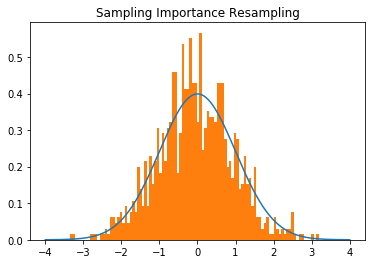

In [114]:
def importance_sampling():
    """利用IM原理对一个已知的正态分布模型进行采样
    """
    def p(x):
    #standard normal
        mu = 0
        sigma = 1
        return 1 / (math.pi*2)**0.5 / sigma*np.exp(-(x-mu)**2 / 2 / sigma**2)
        #uniform proposal distribution on [‐4,4]
    def q(x): #uniform
        return np.array([0.125 for i in range(len(x))])
    #draw N samples that conform to q(x), and then draw M from then that approximately conformc to p(x)
    N = 100000
    M = 1000
    x = (np.random.rand(N) - 0.5) * 8
    w_x = p(x) / q(x)
    w_x = w_x / sum(w_x)
    w_xc = np.cumsum(w_x) #used for uniform quantile inverse
    # resample from x with replacement with probability of w_x
    X = np.array([])
    for i in range(M):
        u = np.random.rand()
        X = np.hstack((X, x[w_xc > u][0]))
    x = np.linspace(-4, 4 ,500)
    plt.plot(x, p(x))
    plt.hist(X, bins=100, density=True)
    plt.title('Sampling Importance Resampling')
    plt.show()
importance_sampling()

'\n'